# Bike Data Analysis
## Introduction
Developers now need to consider a wider range of options to deal with the transport impacts of a development. As Impact Assessors, it is also essential to analyse how access transit and transportation networks will affect the outcome and impact of an urban development project. A key consideration when pursuing an urban development proposal is to understand site accessibility by all modes of transport, with initial emphasis on walk, cycling and public transport.

Such measures may include the preparation of a Travel Plan, financial incentives to encourage alternatives to private car use, infrastructure improvements to make walking and cycling more attractive or public transport service improvements. Some aspects of the Traffic Impact Assessment approach are still relevant to Transport Assessment since most new developments will result in increased traffic in the immediate locality. 

## Steps of analysis
1. Reading all the trip data into Python
- Cleaning the data
- Adding geographic information
- Creating a Network of trips
- Busy Bike Analysis
- Popular trips on the network
- Predicting capacity of a bike station

Lets go!

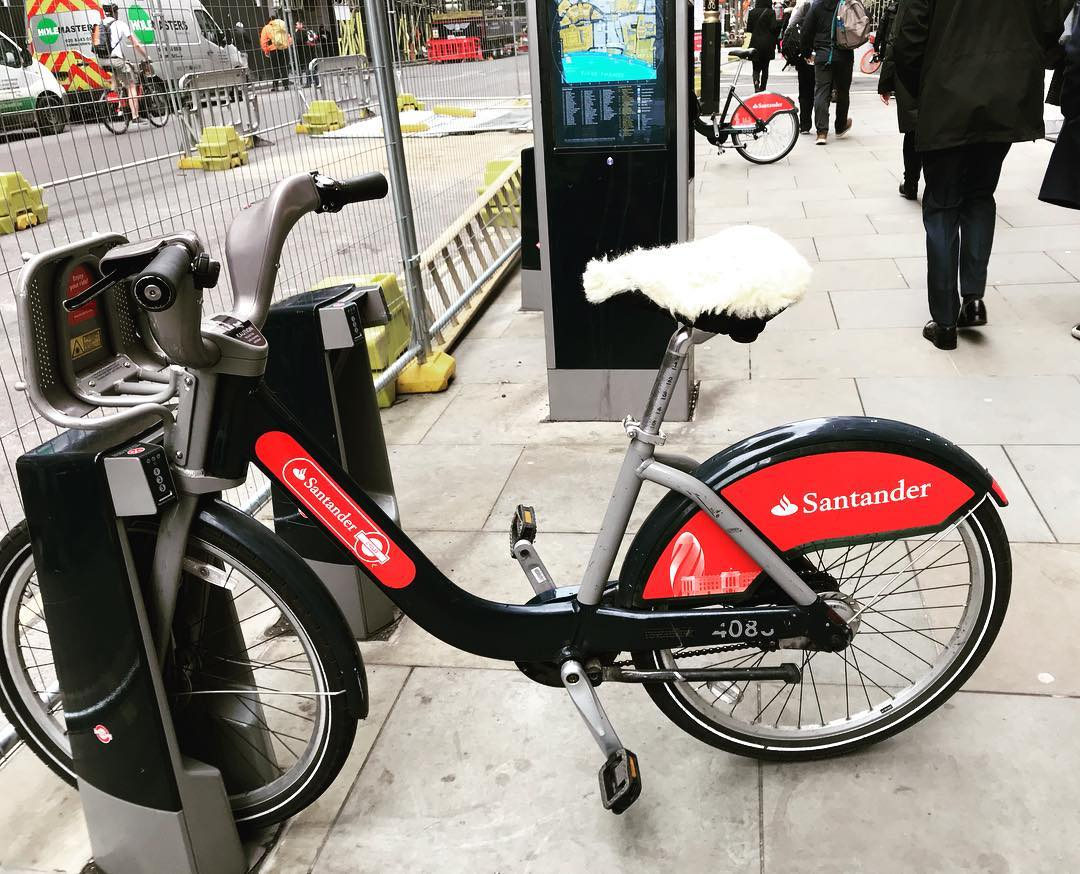

In [4]:
from IPython.display import Image
url = 'https://www.santandercycles.co.uk/sites/default/files/social_content/instagram/53378081_397953404098620_8330148708076807108_n.jpg'
Image(url)

## Santander Cycling data

As part of the free transport data service, Transport for London (TfL) Santander Cycles. The data goes back to January 2012, showing information on the start and end locations of the journey, along with duration and time of day. By combining this information with the coordinates of each cycle hire point, I describe the popularity of routes and the most active stations on the network. The purpose of this analysis it to showcase how metwork analysis and machine learning can help identify important development opportunities in large urban spaces.

For analysis of the full network data (over 48 million trips from 2012-2016) and the technical details, see the Python notebook on my github [here](https://github.com/ChristinaLast/Santander_bike_analysis).

### Reading in bike data for December 2016
Before we can read in any data, we need to load in the appropriate libraries to perform this analysis.

In [28]:
#importing all relevant libraries for the analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, MultiPolygon

%matplotlib inline

import json
from xml.etree import ElementTree as ET
import requests
from io import BytesIO
from io import StringIO

from zipfile import ZipFile
import urllib.request
from urllib.request import urlopen
import os
from pandas.io.json import json_normalize
import itertools
from itertools import chain, starmap
import codecs

### Getting the journey data
The TfL bike usage data is hosted as a number of CSV files on their [website](https://cycling.data.tfl.gov.uk/). I can only download results from 2012-2016 because TfL do not standardise the data coding, and webscraping is impossible as data is hidden. 

In [29]:
#Reading the zipped url of 2016's 
bike_data_2016_zip = urllib.request.urlopen("https://cycling.data.tfl.gov.uk/usage-stats/2016TripDataZip.zip")

In [30]:
# Define function to parse zipfiles to dataframe
def zipfile_to_df(url):    
    with ZipFile(BytesIO(url.read())) as zipfile:
        dfs = []
        for col_name in zipfile.namelist():
            with zipfile.open(col_name) as csv:
                df = pd.read_csv(csv, index_col=None, header=0, encoding='latin1')
                dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    
    return data

In [31]:
bike_2016_df = zipfile_to_df(bike_data_2016_zip)

/Users/clast/test_bike/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [32]:
bike_2016_df

,Bike Id,Duration,End Date,EndStation Id,EndStation Logical Terminal,EndStation Name,Rental Id,Start Date,StartStation Id,StartStation Logical Terminal,StartStation Name,Unnamed: 10,Unnamed: 11,Unnamed: 9,endStationPriority_id
0,11834.0,240.0,10/01/2016 00:04,383.0,NaN,"Frith Street, Soho",50754225,10/01/2016 00:00,18.0,NaN,"Drury Lane, Covent Garden",NaN,NaN,NaN,NaN
1,9648.0,300.0,10/01/2016 00:05,719.0,NaN,"Victoria Park Road, Hackney Central",50754226,10/01/2016 00:00,479.0,NaN,"Pott Street, Bethnal Green",NaN,NaN,NaN,NaN
2,10689.0,1200.0,10/01/2016 00:20,272.0,NaN,"Baylis Road, Waterloo",50754227,10/01/2016 00:00,425.0,NaN,"Harrington Square 2, Camden Town",NaN,NaN,NaN,NaN
3,8593.0,780.0,10/01/2016 00:14,471.0,NaN,"Hewison Street, Old Ford",50754228,10/01/2016 00:01,487.0,NaN,"Canton Street, Poplar",NaN,NaN,NaN,NaN
4,8619.0,600.0,10/01/2016 00:11,399.0,NaN,"Brick Lane Market, Shoreditch",50754229,10/01/2016 00:01,501.0,NaN,"Cephas Street, Bethnal Green",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216383,1708.0,240.0,03/01/2017 21:12,773.0,NaN,"Tallis Street, Temple",61435280,03/01/2017 21:08,388.0,NaN,"Southampton Street, Strand",NaN,NaN,NaN,NaN
10216384,8930.0,300.0,03/01/2017 21:13,633.0,NaN,"Vereker Road North, West Kensington",61435285,03/01/2017 21:08,599.0,NaN,"Manbre Road, Hammersmith",NaN,NaN,NaN,NaN
10216385,4956.0,360.0,03/01/2017 21:39,680.0,NaN,"Westbridge Road, Battersea",61435443,03/01/2017 21:33,701.0,NaN,"Vicarage Crescent, Battersea",NaN,NaN,NaN,NaN
10216386,7005.0,7380.0,03/01/2017 23:36,229.0,NaN,"Whitehall Place, Strand",61435445,03/01/2017 21:33,111.0,NaN,"Park Lane , Hyde Park",NaN,NaN,NaN,NaN


In [34]:
pd.to_datetime(bike_2016_df['Start Date'], infer_datetime_format = True)

0          2016-10-01 00:00:00
1          2016-10-01 00:00:00
2          2016-10-01 00:00:00
3          2016-10-01 00:01:00
4          2016-10-01 00:01:00
                   ...        
10216383   2017-03-01 21:08:00
10216384   2017-03-01 21:08:00
10216385   2017-03-01 21:33:00
10216386   2017-03-01 21:33:00
10216387   2017-03-01 21:34:00
Name: Start Date, Length: 10216388, dtype: datetime64[ns]

In [47]:
mask = (bike_2016_df['Start Date'] > '01/01/2017 00:00:00') & (bike_2016_df['Start Date'] > '11/31/2016 00:00:00')

bike_2016_df.loc[mask]


,Bike Id,Duration,End Date,EndStation Id,EndStation Logical Terminal,EndStation Name,Rental Id,Start Date,StartStation Id,StartStation Logical Terminal,StartStation Name,Unnamed: 10,Unnamed: 11,Unnamed: 9,endStationPriority_id
35379,2139.0,120.0,12/01/2016 00:02,89.0,NaN,"Tavistock Place, Bloomsbury",50791450,12/01/2016 00:00,77.0,NaN,"Russell Square Station, Bloomsbury",NaN,NaN,NaN,NaN
35380,2995.0,900.0,12/01/2016 00:15,155.0,NaN,"Lexham Gardens, Kensington",50791451,12/01/2016 00:00,345.0,NaN,"Flood Street, Chelsea",NaN,NaN,NaN,NaN
35381,4214.0,540.0,12/01/2016 00:09,32.0,NaN,"Leonard Circus , Shoreditch",50791452,12/01/2016 00:00,202.0,NaN,"Leman Street, Aldgate",NaN,NaN,NaN,NaN
35382,8696.0,900.0,12/01/2016 00:16,425.0,NaN,"Harrington Square 2, Camden Town",50791453,12/01/2016 00:01,159.0,NaN,"Great Marlborough Street, Soho",NaN,NaN,NaN,NaN
35383,10605.0,540.0,12/01/2016 00:10,489.0,NaN,"Christian Street, Whitechapel",50791454,12/01/2016 00:01,132.0,NaN,"Bethnal Green Road, Shoreditch",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196815,10261.0,2220.0,01/01/2017 00:35,138.0,NaN,"Green Street, Mayfair",61395899,31/12/2016 23:58,213.0,NaN,"Wellington Arch, Hyde Park",NaN,NaN,NaN,NaN
10196816,2765.0,2220.0,01/01/2017 00:35,138.0,NaN,"Green Street, Mayfair",61395901,31/12/2016 23:58,213.0,NaN,"Wellington Arch, Hyde Park",NaN,NaN,NaN,NaN
10196819,8935.0,3000.0,01/01/2017 00:49,233.0,NaN,"Pall Mall East, West End",61395908,31/12/2016 23:59,105.0,NaN,"Westbourne Grove, Bayswater",NaN,NaN,NaN,NaN
10196820,8912.0,3000.0,01/01/2017 00:49,233.0,NaN,"Pall Mall East, West End",61395906,31/12/2016 23:59,105.0,NaN,"Westbourne Grove, Bayswater",NaN,NaN,NaN,NaN


In [26]:
mask = (bike_2016_df['Start Date'] < '01/01/2017 00:00:00') & (bike_2016_df['Start Date'] > '31/11/2016 00:00:00')
mask

Series([], Name: Start Date, dtype: bool)

In [27]:
bike_2016_df = bike_2016_df.loc[mask]


In [36]:
bike_2016_df

,Bike Id,Duration,End Date,EndStation Id,EndStation Logical Terminal,EndStation Name,Rental Id,Start Date,StartStation Id,StartStation Logical Terminal,StartStation Name,Unnamed: 10,Unnamed: 11,Unnamed: 9,endStationPriority_id
0,11834.0,240.0,10/01/2016 00:04,383.0,NaN,"Frith Street, Soho",50754225,10/01/2016 00:00,18.0,NaN,"Drury Lane, Covent Garden",NaN,NaN,NaN,NaN
1,9648.0,300.0,10/01/2016 00:05,719.0,NaN,"Victoria Park Road, Hackney Central",50754226,10/01/2016 00:00,479.0,NaN,"Pott Street, Bethnal Green",NaN,NaN,NaN,NaN
2,10689.0,1200.0,10/01/2016 00:20,272.0,NaN,"Baylis Road, Waterloo",50754227,10/01/2016 00:00,425.0,NaN,"Harrington Square 2, Camden Town",NaN,NaN,NaN,NaN
3,8593.0,780.0,10/01/2016 00:14,471.0,NaN,"Hewison Street, Old Ford",50754228,10/01/2016 00:01,487.0,NaN,"Canton Street, Poplar",NaN,NaN,NaN,NaN
4,8619.0,600.0,10/01/2016 00:11,399.0,NaN,"Brick Lane Market, Shoreditch",50754229,10/01/2016 00:01,501.0,NaN,"Cephas Street, Bethnal Green",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216383,1708.0,240.0,03/01/2017 21:12,773.0,NaN,"Tallis Street, Temple",61435280,03/01/2017 21:08,388.0,NaN,"Southampton Street, Strand",NaN,NaN,NaN,NaN
10216384,8930.0,300.0,03/01/2017 21:13,633.0,NaN,"Vereker Road North, West Kensington",61435285,03/01/2017 21:08,599.0,NaN,"Manbre Road, Hammersmith",NaN,NaN,NaN,NaN
10216385,4956.0,360.0,03/01/2017 21:39,680.0,NaN,"Westbridge Road, Battersea",61435443,03/01/2017 21:33,701.0,NaN,"Vicarage Crescent, Battersea",NaN,NaN,NaN,NaN
10216386,7005.0,7380.0,03/01/2017 23:36,229.0,NaN,"Whitehall Place, Strand",61435445,03/01/2017 21:33,111.0,NaN,"Park Lane , Hyde Park",NaN,NaN,NaN,NaN
